# Microbial Growth Simulation <br> Starting model
We start with a very simple stochastic model, biologically not very realistic, and then we will move toward more complex models. In this model we consider non-interacting cells, which undergo 2 processes:
- **growth:** the cell size $x(t)$ evolves according to the following equation
    $$
    \dot{x}=g(x(t)) \quad, \quad x(0)=x_b
    $$
- **division:** it is ruled by the _hazard rate function_ $h(x(t))$, which represents the istantaneous probability of the cell to divide. This function is related to the so called _survival function_ $s(t)$, by the relation
    $$
    \frac{\dot{s}(t)}{s(t)}=-h(t) \quad , \quad s(0)=1
    $$
    where $s(t)$ gives the probability that the cell will survive (meaning not divide in this case) past a certain time $t$.

While the growth is a deterministic process, division is a stochastic event. In this first model we define $g(x)$ and $h(x)$ as 2 linear functions
$$
\begin{aligned}
g(x) &\equiv \omega_1(\mu+x) \\
h(x) &\equiv \omega_2(1+x/\nu)
\end{aligned}
$$
where $\omega_1$ and $\omega_2$ are frequencies, while $\mu$ and $\nu$ are sizes (tipycally measured in $\mu m$). The ratio between $\omega_1$ and $\omega_2$ is the order parameter that triggers the phase transition. The parameters $\mu$ and $\nu$ are necessary to cut off the probability distribution (in zero and for large values of $x$), which is important both for physical reasons and for making the distribution normalizable. Introducing these parameters is a mathematical trick, useful for example to prevent the cell from having a too small size, which however is difficult to justify from a biological point of view. We will then see better models, biologically speaking.

To sum up, our set of parameters is 
$$
\underline{\theta}=\{\mu, \nu, \omega_1, \omega_2, x_b\}
$$

## Simulation process
The idea is first of all to solve analytically the following differential equation for the size $x(t)$ of one single cell
$$
\begin{dcases}
x(0) =  x_b  \\
\dot{x} = \omega_1 \left(x(t) + u\right)
\end{dcases}
$$
where $x_b$ is the cell size at birth. 

Then, we plug $x(t)$ into
$$
h(x(t)) = \omega_2 \left(1 + \frac{x(t)}{\nu}\right)
$$


Next, we use the found result for $h(x(t))$ to solve:
$$
\begin{dcases}
s(0) =  1  \\
\dfrac{\dot{s}(t)}{s(t)} = -h(x(t))
\end{dcases}
$$
Once we have $s(t)$ we can generate random division times from this distribution using the **inverse transform method**. Finally, we can deterministically propagate the solution to find $x(t)$. 


## Analytical solution of the differential equations
The result of two differential equations is:
$$
\begin{aligned}
s(t) &= \exp\left\{ \omega_2t \left(\frac{u}{\nu}-1\right) + \frac{\omega_2}{\omega_1}\left(\frac{u + x_b}{\nu}\right)(1-e^{\omega_1t})\right\} \\
\ln(s) &= \omega_2 t \left(\frac{u}{\nu}-1\right) + \frac{\omega_2}{\omega_1} \left(\frac{u+x_b}{\nu}\right) (1-e^{\omega_1 t})
\end{aligned}
$$

and $x(t)$ is given by
$$
x(t) = \left(x_b+\frac{\mu}{\omega_1}\right)e^{\omega_1 t}-\frac{\mu}{\omega_1}
$$


## Sampling from the distribution
Following the inverse transform method, to draw a division time, $t_d$, from the associated distribution, we draw a random value $s(t)$ from a uniform distribution in the intervall $[0, 1]$ (i.e. “draw a survival probability”) and solve for $t_b$

$$ 
\log(s(t_b)) = \log(K)
$$


In systems with many cells, the division times will generally be very small. Therefore, in this case it is possible to expand the equation found for $s(t)$ up to the second order in $t$ and solve the resulting equation, deriving the approximate division time:

$$
 t_b = - \dfrac{1}{\omega_1} \left(\dfrac{x_b + \nu}{x_b + u}\right) + \dfrac{1}{\omega_1} \left(\dfrac{\nu}{x_b + u}\right) \sqrt{\left( \dfrac{x_b}{\nu} +1 \right)^{2} -2 \cdot \dfrac{\omega_1}{\omega_2} \left(\dfrac{x_b + u}{\nu}\right) \log(K) }

$$

**However, in our case, since we deal with the evolution of one single cell, this approximation cannot be applied and the function $s(t)$ must be inverted numerically.**
We use the library [Pyinverse](https://pypi.org/project/pynverse/) to find numerically the inverse of a function.

In [ ]:
import math
import numpy as np
from scipy import stats
#import sympy as smp
from pynverse import inversefunc
import pandas as pd
# from sympy.abc import t, a, b, c, d, e
import emcee
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import seaborn as sns

In [ ]:
import plotly.express as px

In [ ]:
np.random.seed(seed=123)

size = 100 # length of the time series (= number of divisions)
s_drawn = np.random.uniform(low=0, high = 1, size = size)
print('Some drawn values of s:', s_drawn[:5])

Some drawn values of s: [0.69646919 0.28613933 0.22685145 0.55131477 0.71946897]


In [ ]:
# In the following code cell we rename:
# - $a=\omega_1$
# - $b=\omega_2$
# - $c=\mu$
# - $d=\nu$
# - $e=x_b$

# def x(t):
#     return(np.e**((b*t*(c-1) + (a/b)*((c + e)/d)*(1-np.e**(-a*t)))))

#smp.solve(x(t)-0.5, t)    #find the value of t in which x(t) - 0.5 = 0 

## Parameters value, initial choices
Initially, we can choose arbitrary values for the parameters, as long as they make sense. For this reason, we decide to set and fix
- $\omega_1=1$
- $\nu=1$

Then we chose for now
- $\omega_2=0.9$ 
- $\mu=0.1$, such that $\mu \ll\nu$
- $x_b=1$


In [ ]:
'''
Cell size evolution x(t)
'''
def x_function(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    x = (xb+mu/omega1)*np.exp(omega1*t)-mu/omega1
    return x
    
'''
Hazard rate function h(t)
'''
def h(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    h = omega2*(1+x_function(t, pars)/nu)
    return h

'''
Survival function s(t)
'''
def CDF(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    s = np.exp(omega2*t*(mu/nu - 1) + (omega1/omega2)*((mu + xb)/nu)*(1-np.exp(omega1*t)))
    return s

In [ ]:
# def log_s (t, pars):
#     (omega1, omega2, u, nu, xb) = pars
# 
#     log_s_t = (omega2/omega1)*((xb+u)/nu) + omega2*(u/nu - 1)*t - (omega2/omega1)*((xb+u)/nu)*np.exp(omega1*t)
#     return log_s_t

'''
Find tau analytically, using the second order approximation
'''
def draw_tau(K, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    tau = -(1/omega1)*((xb+nu)/(xb+mu)) + (1/omega1)*(nu/(xb+mu)) * np.sqrt((1+xb/nu)**2 - 2*(omega1/omega2)*((xb+mu)/nu)*np.log(K))
    return tau


'''
Find tau numerically
'''
def draw_tau_numerical(K, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars
    tau = inversefunc(CDF, args=(pars,), y_values=K)
    
    return tau



In [ ]:
# numerical inversion of CDF function
# sim_t = draw_tau_numerical(s_drawn)
# df_growth = pd.DataFrame({'simulated_tau':sim_t, 's_drawn':s_drawn})

# display(df_growth)

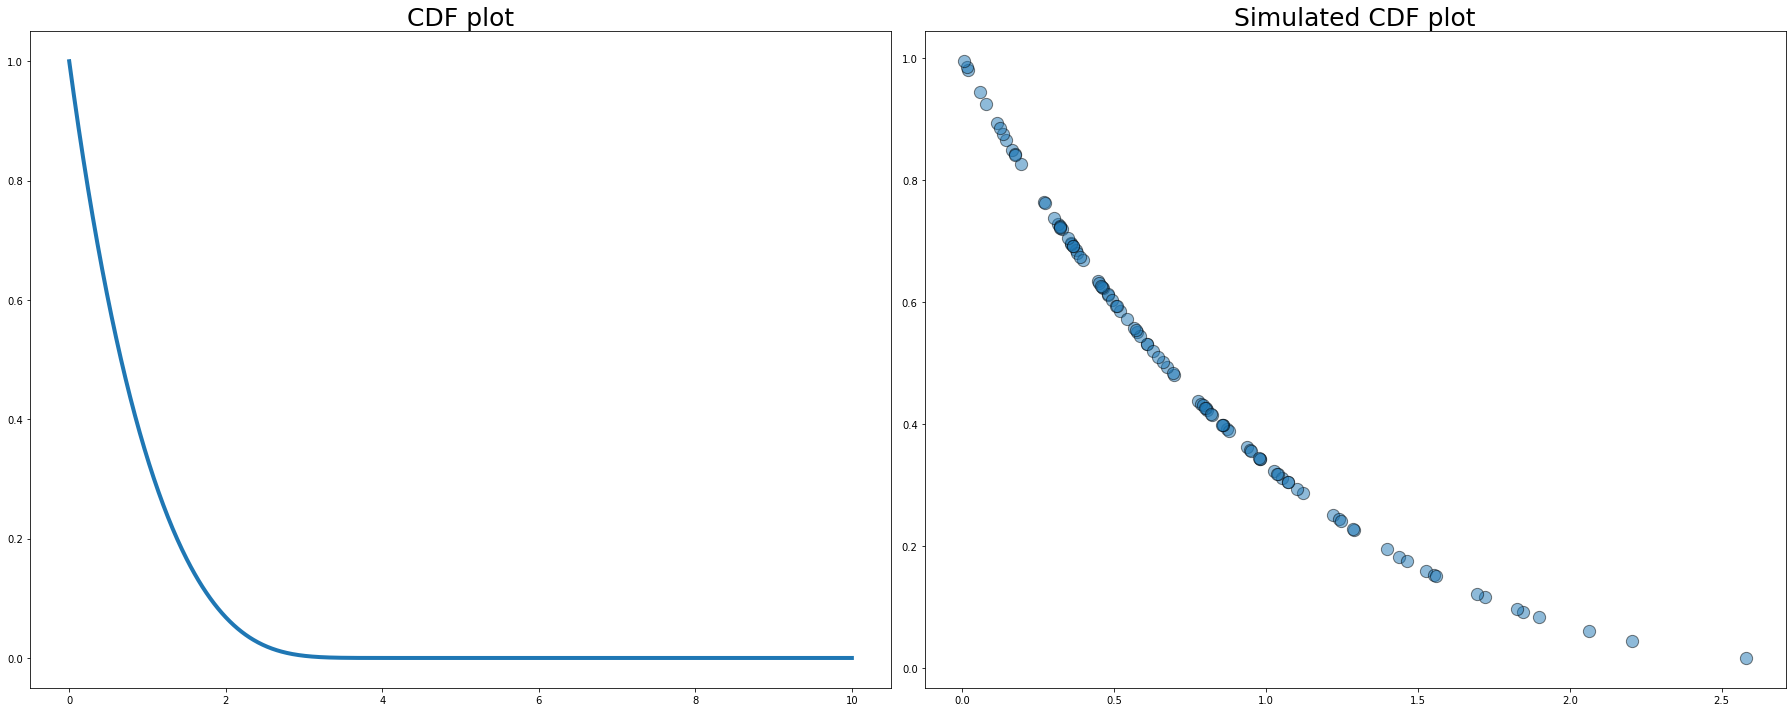

In [ ]:
sim_t = draw_tau_numerical(s_drawn,(1,0.9,0.1,1,0.05))

# plot of CDF
fig, ax = plt.subplots(1,2 , figsize=(25, 10))
ax[0].plot(np.linspace(0,10,1000), CDF(np.linspace(0,10,1000),(1,0.9,0.1,1,0.05)), linewidth=4)
ax[0].set_title('CDF plot', fontsize=25)
ax[1].set_title('Simulated CDF plot', fontsize=25)
ax[1].scatter(sim_t, CDF(sim_t,(1,0.9,0.1,1,0.05)), alpha=0.5, edgecolor='black', s=150)
fig.tight_layout()

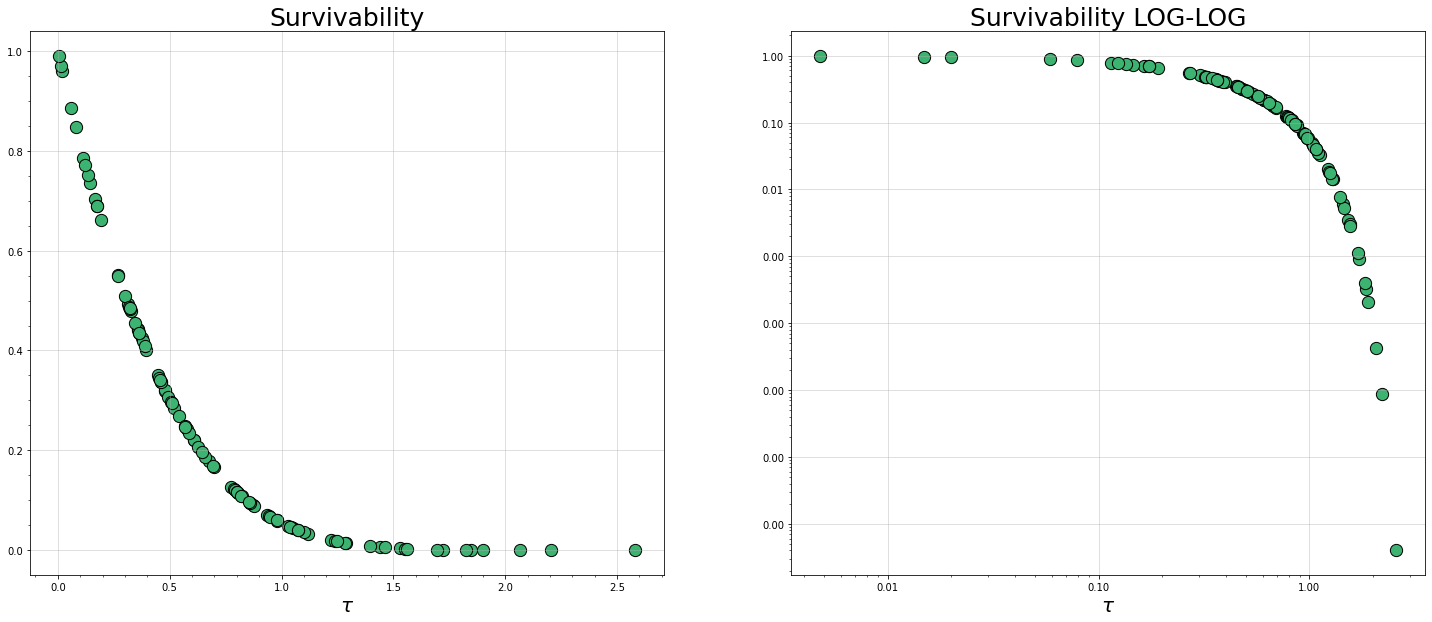

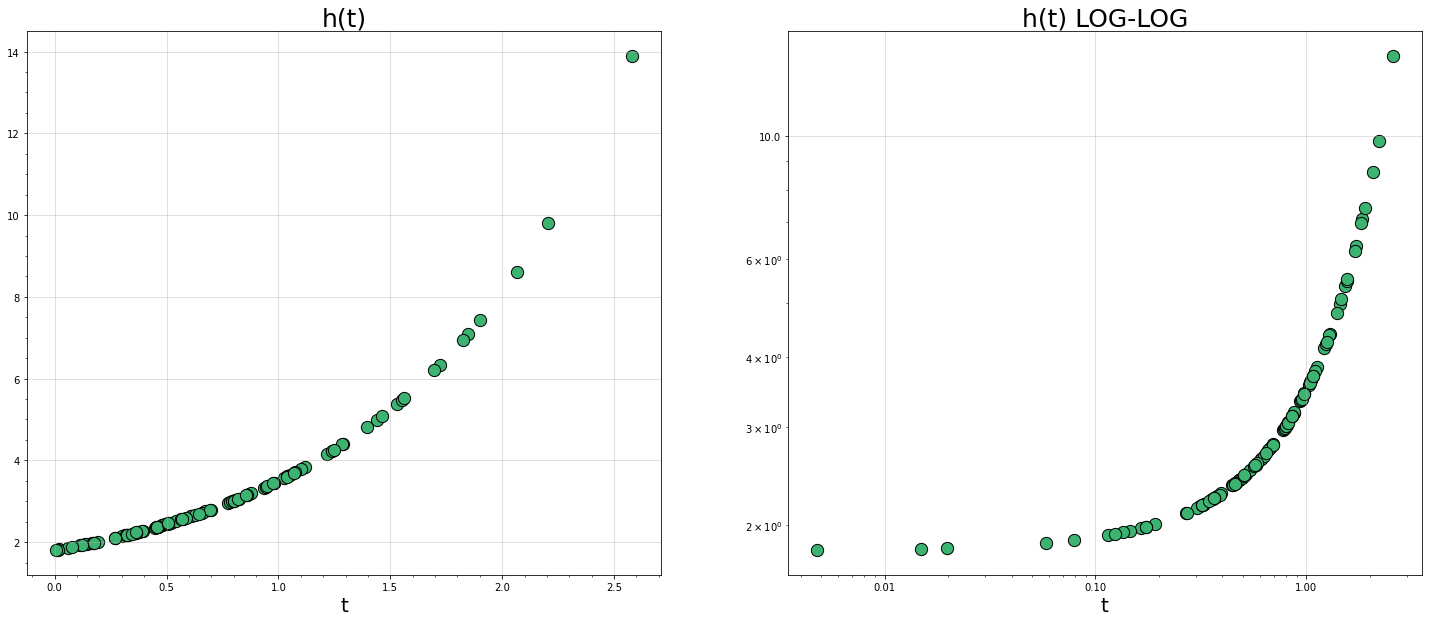

In [ ]:
# PLOT s(t)
fig, ax = plt.subplots(1,2 , figsize=(25, 10))
ax[0].scatter(sim_t, CDF(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[0].set_title('Survivability', fontsize=25)
ax[0].set_xlabel('$\\tau$', fontsize = 20)
ax[0].minorticks_on()
ax[0].grid(alpha=0.5)

ax[1].scatter(sim_t, CDF(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[1].set_title('Survivability LOG-LOG', fontsize=25)
ax[1].set_xlabel('$\\tau$', fontsize = 20)
ax[1].minorticks_on()
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid(alpha=0.5)
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# PLOT h(t)
fig, ax = plt.subplots(1,2 , figsize=(25, 10))
ax[0].scatter(sim_t, h(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[0].set_title('h(t)', fontsize=25)
ax[0].set_xlabel('t', fontsize = 20)
ax[0].minorticks_on()
ax[0].grid(alpha=0.5)

ax[1].scatter(sim_t, h(sim_t), s=150, color='mediumseagreen', edgecolor='black')
ax[1].set_title('h(t) LOG-LOG', fontsize=25)
ax[1].set_xlabel('t', fontsize = 20)
ax[1].minorticks_on()
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid(alpha=0.5)
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

## Forward propagation
At this point, given the time series of the survival times, we can forward propagate the evolution of a single cell, according to the following procedure:

1. Start with the initial size $x_b$
2. Propagate using the equation for $x(t)$ up to the first division time
3. Divide the cell size by 2 (assuming the cell divides equally in two parts)
4. Repeat the last 2 points for all division times generated, imposing as initial size of the cell the one after division and resetting the time

Recall that in this model the cell growth is a deterministic process, while the division is stochastic.


In [ ]:
points_per_evolution=100     # number of time points between 2 divisions

t = 0
xb = 1

all_times = np.zeros(points_per_evolution*size)
cell_sizes = np.zeros(points_per_evolution*size)
sim_t = []

for i in range(size): 
    parameters = (1,0.9,0.1,1,xb) # omega1, omega2, mu, nu, xb
    tau = draw_tau_numerical(s_drawn[i], pars=parameters)
    sim_t.append(tau)

    # evolution
    times = np.linspace(0, tau, points_per_evolution)
    xt = x_function(times, parameters)
    
    # store times and sizes
    all_times[i*points_per_evolution : (i+1)*points_per_evolution] = np.linspace(t, t+tau, points_per_evolution)
    cell_sizes[i*points_per_evolution : (i+1)*points_per_evolution] = xt

    # update the initial time and the starting size
    xb = xt[-1]/2
    t = t+tau

sim_t = np.array(sim_t)


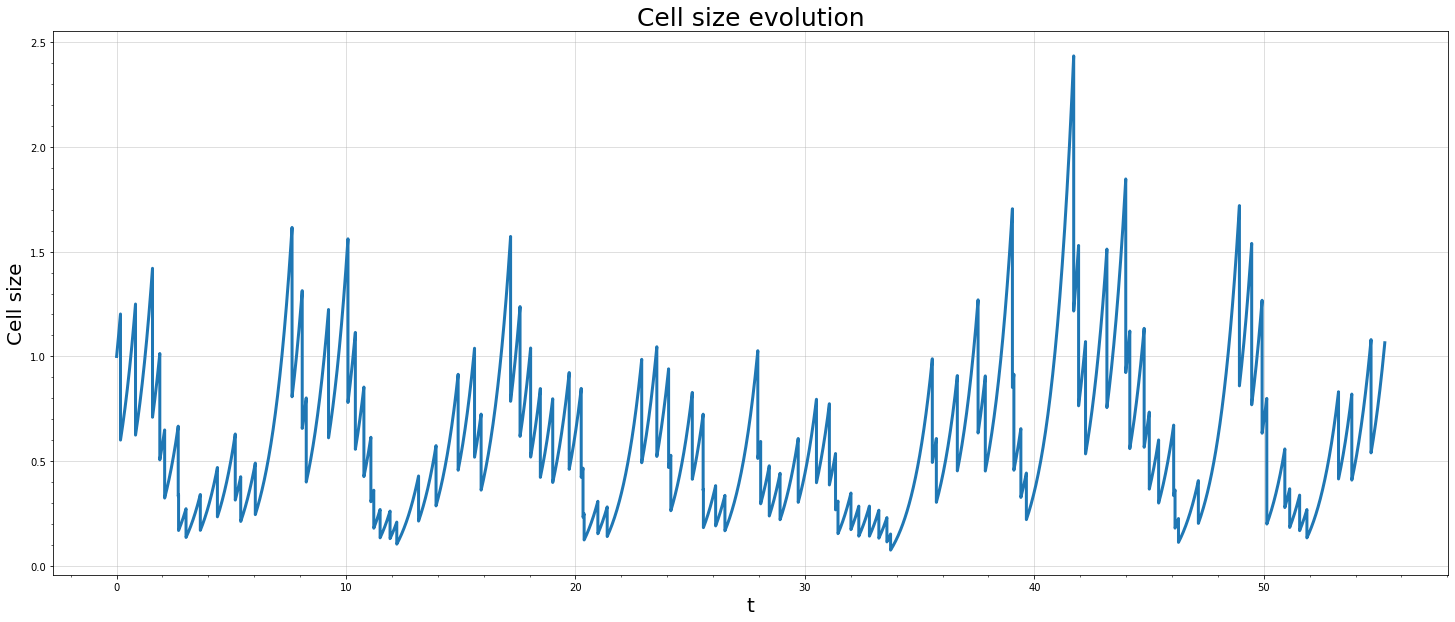

In [ ]:
fig, ax = plt.subplots(1,1 , figsize=(25, 10))
ax.plot(all_times, cell_sizes, linewidth=3, color='C0')
ax.set_title('Cell size evolution', fontsize=25)
ax.set_xlabel('t', fontsize = 20)
ax.set_ylabel('Cell size', fontsize=20)
ax.minorticks_on()
ax.grid(alpha=0.5)

## Priors 
For now, we consider $\omega_1$, $\nu$ and $x_b$ constant, so that the only parameters to be inferred are $\omega_2$ and $\mu$. 

For $\omega_2$, we choose as prior a log-normal distribution. This is motivated by the fact that $\omega_2$ must be positive. Moreover, according to the previous choices of the parameter values, we set as parameters $\mu=\frac{1}{3}$ and $\sigma = \sqrt{\frac{1}{3} - log(0.9)} $. 

Instead, as $\mu$ must be smaller than $\nu$ and we imposed $\nu=1$, we adopt for $\mu$ a beta prior, which is restricted between 0 and 1. Assuming a greater probability for values closer to zero than to one and a pdf that goes to zero in both extremes, one possible choice can be to set $\alpha=2$ and $\beta=5$. 

<br>

**Some information on the log-normal distribution** <br>
The pdf of the log-normal distribution is characterized by 2 parameters:
- $\mu$: the location parameter
- $\sigma$ the scale parameter

These two parameters must not be confused with the mean and standard deviation of the distribution. When the log-normal data is transformed using logarithms, then $\mu$ can then be viewed as the mean (of the transformed data) and $\sigma$ as the standard deviation (of the transformed data). But without these transformations $\mu$ and $\sigma$ here are simply two parameters that define our log-normal, not the mean or standard deviation! Reference: [Log-normal Distribution - A simple explanation](https://towardsdatascience.com/log-normal-distribution-a-simple-explanation-7605864fb67c). 

About how this parameters are managed by `scipy`, we report here what is described in the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html).


We have that 
$$
Mode(x) = e^{\mu - \sigma^2}
$$

> To shift and/or scale the distribution use the loc and scale parameters. Specifically, lognorm.pdf(x, s, loc, scale) is identically equivalent to lognorm.pdf(y, s) / scale with y = (x - loc) / scale. Note that shifting the location of a distribution does not make it a “noncentral” distribution; noncentral generalizations of some distributions are available in separate classes. 
>
> A common parametrization for a lognormal random variable Y is in terms of the mean, mu, and standard deviation, sigma, of the unique normally distributed random variable X such that exp(X) = Y. This parametrization corresponds to setting s = sigma and scale = exp(mu).

In [ ]:
# define the distributions
def prior_omega2(omega2):
    return(stats.lognorm.pdf(omega2, s=np.sqrt(1/3 - np.log(0.9)), loc=0, scale=np.exp(1/3 )))

def prior_mu(mu):
    return(stats.beta.pdf(mu, a=2, b=5))

def prior_nu(nu):
    return(stats.lognorm.pdf(nu, s=1/3, loc=0.1, scale=np.exp(1/9)))

def prior_omega1(omega1):
    return(stats.lognorm.pdf(omega1, s=1/3, loc=0, scale=np.exp(1/9)))

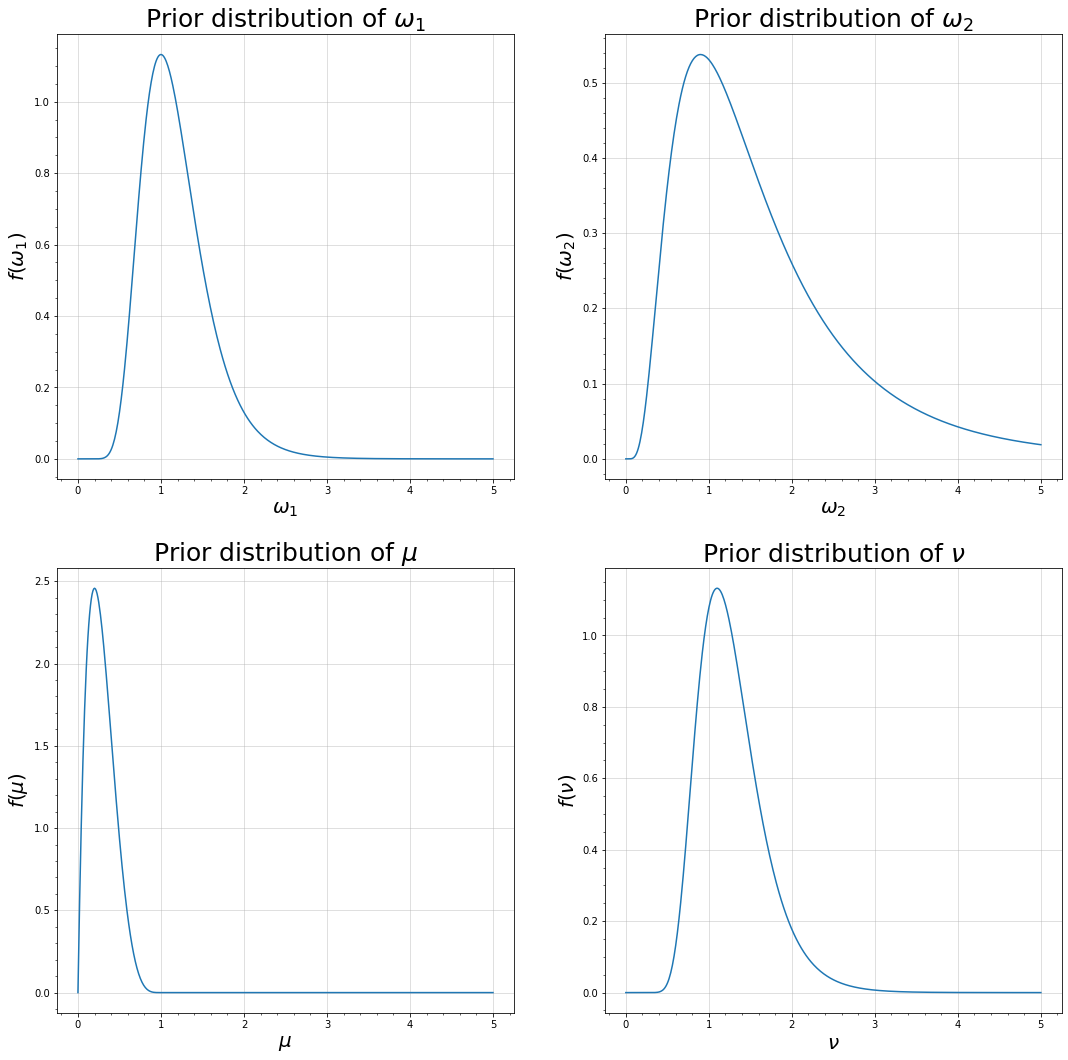

In [ ]:
x = np.linspace(0, 5, 500)

_, ax = plt.subplots(2, 2, figsize=(18, 18))
ax[0, 0].plot(x, prior_omega1(x))
ax[0, 1].plot(x, prior_omega2(x)) 
ax[1, 0].plot(x, prior_mu(x)) 
ax[1, 1].plot(x, prior_nu(x))

param_str = [['$\omega_1$', '$\omega_2$'], ['$\mu$', '$\\nu$']]

for i in range(2):
    for j in range(2):
        ax[i, j].set_title('Prior distribution of ' + param_str[i][j], fontsize=25)
        ax[i, j].set_xlabel(param_str[i][j], fontsize=20)
        ax[i, j].set_ylabel('$f($'+param_str[i][j]+'$)$', fontsize=20)
        ax[i, j].minorticks_on()
        ax[i, j].grid(alpha=0.5)

## Likelihood

To retrieve the likelihood we first retrieve the pdf as minus the derivative of the cdf.
We then have that 
$$
f(y|\theta) = \prod_i f(t_i|t_{i-1,..}, \theta)
$$

In [ ]:
def PDF_old(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars
    unnormalized = -1*CDF(t, pars=pars) * (omega2*((mu/nu) - 1) - omega2*((mu + xb)/nu) * np.exp(omega1*t))
    idx = np.argsort(t)
    normalization = np.trapz(x=t[idx], y=unnormalized[idx])
    return(unnormalized/normalization)


def PDF(t, pars=(1,0.9,0.1,1,1)):
    (omega1, omega2, mu, nu, xb) = pars

    unnormalized = h(t, pars)*CDF(t, pars)
    idx = np.argsort(t)
    normalization = np.trapz(x=t[idx], y=unnormalized[idx])

    return(unnormalized/normalization)

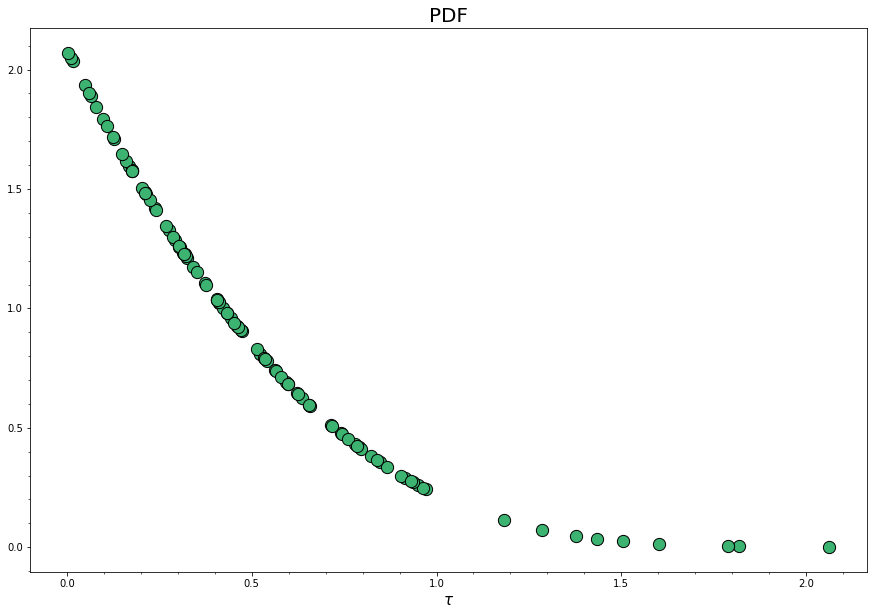

In [ ]:
def likelihood(y, pars=(1,0.9,0.1,1,1)):
    return np.prod(PDF(y, pars))

def log_likelihood(y, pars=(1,0.9,0.1,1,1)):
    return np.sum(np.log(PDF(y, pars)))

fig, ax = plt.subplots(1,1 , figsize=(15, 10))
ax.scatter(sim_t, PDF(sim_t, pars=(1,0.9,0.1,1,1)), s=150, color='mediumseagreen', edgecolor='black')
ax.set_title('PDF', fontsize=20)
ax.set_xlabel('$\\tau$', fontsize = 15)
ax.minorticks_on()

## Metropolis algorithm - Implementation from scratch

### This first part acts only on $\omega_2$
The goal is to estimate the value of the parameter $\omega_2$ from the simulated data. In order to do this, we use the log distributions. 

In [ ]:
# function that 'proposes' a new sample
# that will be eventually accepted of rejected
def jump_distribution(mean_omega = 1):
    draw = np.random.normal(loc=mean_omega, scale=0.5, size=1)
    return(float(draw))

In [ ]:
def unnorm_posterior(y_times, omega_2):
    return(likelihood(y_times, pars=(1, omega_2, 0.1, 1, 1)) * prior_omega2(omega_2))

def log_unnorm_posterior(y_times, omega_2):
    return(log_likelihood(y_times, pars=(1, omega_2, 0.1, 1, 1)) + np.log(prior_omega2(omega_2)))

In [ ]:
def post_sampler(array, jump, initial, num_sampled, maxiter=1000000):
    np.random.seed(12345)

    samples_post = []
    omega_2 = initial
    samples_post.append(omega_2)
    
    sampled = 1
    i=0

    while (sampled < num_sampled and i<maxiter):
        #print(sampled)

        proposal = jump(omega_2)
        prob = np.min([1, (unnorm_posterior(array,proposal))/(unnorm_posterior(array, omega_2))])
        cutoff = np.random.uniform(size=1)

        if cutoff <= prob:
            omega_2 = proposal
            samples_post.append(proposal)
            sampled +=1
        
        i+=1
    
    return(np.array(samples_post))


def log_post_sampler(array, jump, initial, num_sampled, maxiter=1000000):
    np.random.seed(12345)

    samples_post = []
    omega_2 = initial
    samples_post.append(omega_2)
    
    sampled = 1
    i=0

    while (sampled < num_sampled and i<maxiter):
        #print(sampled)

        proposal = jump(omega_2)
        prob = np.min([1, np.exp(log_unnorm_posterior(array,proposal)-log_unnorm_posterior(array, omega_2))])
        cutoff = np.random.uniform(size=1)

        if cutoff <= prob:
            omega_2 = proposal
            samples_post.append(proposal)
            sampled +=1
        
        i+=1
    
    return(np.array(samples_post))
        

In [ ]:
def unnorm_post(tmp, omega_2):
    return(likelihood(tmp, pars=(1, omega_2, 0.1, 1, 1)) * prior_omega2(omega_2))
    
unnorm_post(sim_t, 0.9)
# yaxis = yaxis[idx]
# normalization = np.trapz(x=y_times, y=unnorm_post(y, omega_2))

2.415135657406256e-22

In [ ]:
# using log distribution
sample = log_post_sampler(array=sim_t, jump=jump_distribution, initial = 0.9, num_sampled=10000)
sample[0:20]

<ipython-input-17-97fed9f27c33>:5: RuntimeWarning: divide by zero encountered in log
  return(log_likelihood(y_times, pars=(1, omega_2, 0.1, 1, 1)) + np.log(prior_omega2(omega_2)))
<ipython-input-5-0729c5d6e9ad>:25: RuntimeWarning: overflow encountered in exp
  s = np.exp(omega2*t*(mu/nu - 1) + (omega1/omega2)*((mu + xb)/nu)*(1-np.exp(omega1*t)))
<ipython-input-14-8695b04bc8d9>:16: RuntimeWarning: invalid value encountered in true_divide
  return(unnormalized/normalization)


KeyboardInterrupt: 

Text(0.5, 1.0, '$\\omega_2$ posterior')

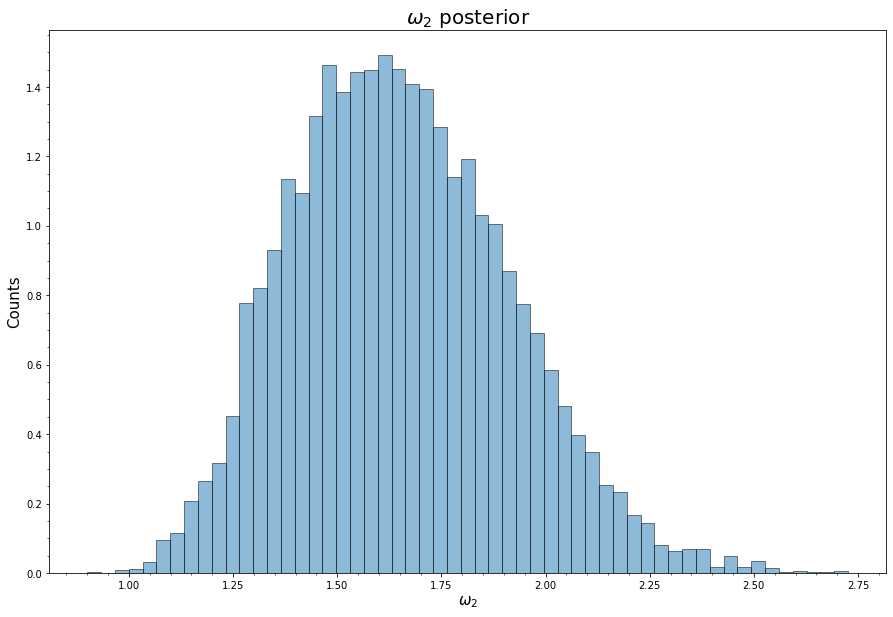

In [ ]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))
ax.hist(sample, edgecolor='black', alpha = 0.5, bins='fd', density = True)
ax.minorticks_on()
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('$\\omega_2$', fontsize=15)
ax.set_title('$\\omega_2$ posterior', fontsize=20)

### This part acts on both $\omega_2$ and $\mu$
In this case we don't use the log distributions, as some warnings still occured in the previous section (e.g. "divide by zero encountered in log"). If we will solve the problem in the one-dimensional case, than we will use that approch in this part as well. 

The goal is to infer from the simulated data both $\omega_2$ and $\mu$. 

In [ ]:
def joint_jump(mean_omega = 1, mean_mu = 1):
    draw = np.random.multivariate_normal(mean=[mean_omega, mean_mu], cov = [[1, 0], [0, 1]])
    return(draw)

In [ ]:
def joint_posterior(y, omega_2, mu):
    return(likelihood(y, pars=(1, omega_2, 0.1, 1, 1)) * prior_omega2(omega_2) * prior_mu(mu))

In [ ]:
def joint_post_sampler(array, jump, initial, num_iterations):
    samples_omega = []
    samples_mu = []
    omega_2 = initial[0]
    mu_ = initial[1]
    samples_omega.append(omega_2)
    samples_mu.append(mu_)
    for i in range(num_iterations):
        proposal = jump(omega_2, mu_)
        prob = np.min([1, (joint_posterior(array,proposal[0], proposal[1]))/(joint_posterior(array, omega_2, mu_))])
        cutoff = np.random.uniform(size=1)
        if cutoff <= prob:
            omega_2 = proposal[0]
            mu_ = proposal[1]
            samples_omega.append(proposal[0])
            samples_mu.append(proposal[1])
    
    return(samples_omega, samples_mu)

In [ ]:
sample_omega, sample_mu = joint_post_sampler(array=sim_t, jump=joint_jump, initial=[0.9, 0.1], num_iterations=10000)

<ipython-input-5-0729c5d6e9ad>:25: RuntimeWarning: overflow encountered in exp
  s = np.exp(omega2*t*(mu/nu - 1) + (omega1/omega2)*((mu + xb)/nu)*(1-np.exp(omega1*t)))
<ipython-input-14-8695b04bc8d9>:16: RuntimeWarning: invalid value encountered in true_divide
  return(unnormalized/normalization)


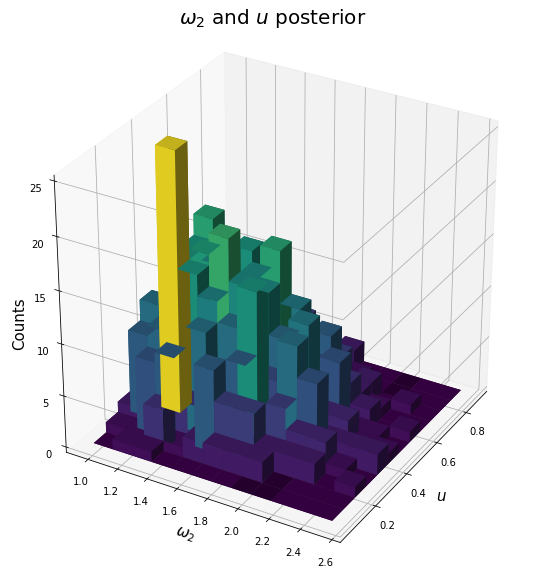

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
hist, xedges, yedges = np.histogram2d(sample_omega, sample_mu, bins=(12,12))
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)
cmap = cm.get_cmap('viridis')
# Construct arrays with the dimensions for the bars.


dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]

dz = hist.ravel()
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
rgba = [cmap((k-min_height)/max_height) for k in dz]
ax.set_xlabel('$\\omega_2$', fontsize=15)
ax.set_ylabel('$u$', fontsize=15)
ax.set_box_aspect([1,1,1])
tmp_planes = ax.zaxis._PLANES
ax.zaxis._PLANES = ( tmp_planes[2], tmp_planes[3], 
                     tmp_planes[0], tmp_planes[1], 
                     tmp_planes[4], tmp_planes[5])
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel("Counts" , fontsize=15, rotation=90)
ax.set_title('$\\omega_2$ and $u$ posterior', fontsize=20)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
fig.tight_layout()

In [ ]:
import plotly.express as px
fig=px.density_heatmap(x=sample_omega, y=sample_mu, nbinsx=16, nbinsy=16, width=700, height=500, marginal_y='histogram', marginal_x='histogram')
xmin, xmax, ymin, ymax = xedges[0], xedges[-1], yedges[0], yedges[-1]

fig.update_layout(
    title="Posterior heatmap",
    xaxis_title="$\omega_2$",
    yaxis_title="$\mu$",
)
fig.show()

In [ ]:
import plotly.graph_objects as go

import numpy as np

fig = go.Figure(go.Histogram2dContour(
        x = sample_omega, 
        y = sample_mu,
        colorscale = 'Blues', 
        contours = dict(
            showlabels = True,
            labelfont = dict(
                family = 'Raleway',
                color = 'firebrick', 
                size=20
            )
        ),
))

fig.update_layout(
    title="Posterior heatmap",
    xaxis_title="$\omega_2$",
    yaxis_title="$\mu$",
)

fig.show()

Median value of omega_2: 1.712
Maximum value of omega_2: 1.5025
Median value of mu: 0.3021
Maximum value of mu: 0.134


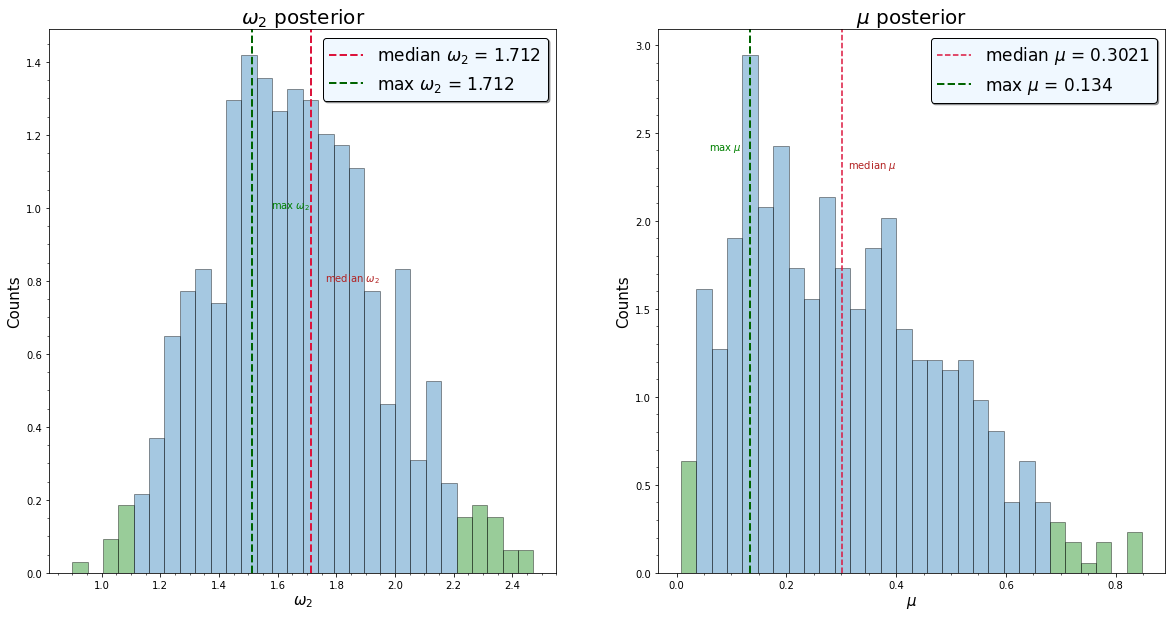

In [ ]:
fig, ax = plt.subplots(1,2 , figsize=(20, 10))

# OMEGA
res_omega = ax[0].hist(sample_omega, edgecolor='black', alpha = 0.4, bins=30, density = True)
counts_omega = res_omega[0]
edges_omega = res_omega[1]
patches_omega = res_omega[2]
tmp = np.cumsum(np.diff(edges_omega)*counts_omega)

max_index = np.argmax(counts_omega)
max_omega = (edges_omega[max_index] + edges_omega[max_index + 1])/2
median_omega = (edges_omega[len(tmp[tmp<0.5])+1] + edges_omega[len(tmp[tmp<0.5])+2])/2
print('Median value of omega_2:', round(median_omega, 4))
print('Maximum value of omega_2:', round(max_omega, 4))
for i in range(len(tmp[tmp<0.025])):
    patches_omega[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_omega[i].set_facecolor('green')

ax[0].minorticks_on()
ax[0].set_ylabel('Counts', fontsize=15)
ax[0].set_xlabel('$\\omega_2$', fontsize=15)
ax[0].set_title('$\\omega_2$ posterior', fontsize=20)
ax[0].axvline(median_omega, color='crimson', linestyle='dashed',  linewidth=2 , label='median $\omega_2$ = ' + str(round(median_omega, 4)))
ax[0].axvline(max_omega+0.01, color='darkgreen', linestyle='dashed',  linewidth=2, label='max $\omega_2$ = ' + str(round(median_omega, 4)))
ax[0].text(median_omega+0.05, 0.8, 'median $\omega_2$', color='firebrick')
ax[0].text(max_omega+0.075, 1, 'max $\omega_2$', color='green')

ax[0].legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')

# MU
res_mu = ax[1].hist(sample_mu, edgecolor='black', alpha = 0.4, bins=30, density = True)
counts_mu = res_mu[0]
edges_mu = res_mu[1]
patches_mu = res_mu[2]

tmp = np.cumsum(np.diff(edges_mu)*counts_mu)
max_index = np.argmax(counts_mu)
max_mu = (edges_mu[max_index] + edges_mu[max_index + 1])/2
median_mu = (edges_mu[len(tmp[tmp<0.5])+1] + edges_mu[len(tmp[tmp<0.5])+2])/2

print('Median value of mu:', round(median_mu, 4))
print('Maximum value of mu:', round(max_mu, 4))

for i in range(len(tmp[tmp<0.025])):
    patches_mu[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_mu[i].set_facecolor('green')


ax[1].minorticks_on()
ax[1].set_ylabel('Counts', fontsize=15)
ax[1].set_xlabel('$\\mu$', fontsize=15)
ax[1].set_title('$\\mu$ posterior', fontsize=20)
ax[1].axvline(median_mu, color='crimson', linestyle='dashed', label='median $\\mu$ = ' + str(round(median_mu, 4)))
ax[1].axvline(max_mu, color='darkgreen', linestyle='dashed',  linewidth=2 , label='max $\\mu$ = ' + str(round(max_mu, 4)))
ax[1].text(median_mu+0.01, 2.3, 'median $\mu$', color='firebrick')
ax[1].text(max_mu-0.075, 2.4, 'max $\mu$ ', color='green')

ax[1].legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')


plt.show()

### Results
Since the values of the parameters used to generate the data are known, because they are imposed at the beginning, in this case we can compare the inferred values with the true ones.

About $\mu$, the result of the inference procedure is 
- $\text{median}(\mu)=0.2851$ 
- $\text{max}(\mu)=0.1981$

The predicted value of $\mu$ is correctly much smaller than $\nu$ and similar to the true value. 

Regarding $\omega_2$, even though the characteristic values of $\omega_2$ 
- $\text{median}(\omega_2)=1.1404$ 
- $\text{max}(\omega_2)=1.1404$

are close to the true value.

## Metropolis–Hastings algorithm (emcee)
In this case we work in a three dimensional parameter space, where $\omega_1$, $\omega_2$ and $\mu$ have to be inferred from the simulated data.  

In [ ]:
n_walkers = 20
ndim = 3

def j_log_unnorm_posterior_emcee(params, y_times):
    try:
        omega_1, omega_2, u, nu = np.array(params)
        
        #return(log_likelihood(y_times, pars=(1, omega_2, u, 1, 1)) + np.log(prior_omega2(omega_2)) + np.log(prior_mu(u)) + np.log(prior_omega1(omega_1))
    except:
        #omega_1, omega_2, u = np.array([0.00001, 0.000001, 0.00001])
        post_arr = [1, 0.9, 0.1, 1]
    
    ret = log_likelihood(y_times, pars=(omega_1, omega_2, u, nu, 1)) + np.log(prior_omega2(omega_2)) + np.log(prior_mu(u)) + np.log(prior_omega1(omega_1)) + np.log(prior_nu(nu))
    
    if ret*0 ==0:
        return(ret)
    else:return(-np.inf)
    


In [ ]:
p0_u = np.random.uniform(low=0.01, high=0.3, size=n_walkers).reshape(-1, 1)
p0_omega_2 =np.random.uniform(low=0.5, high=1.2, size=n_walkers).reshape(-1, 1)
p0_omega_1 = np.random.uniform(low=0.6, high=1.3, size=n_walkers).reshape(-1, 1)
p0_nu = np.random.uniform(low=0.6, high=1.3, size=n_walkers).reshape(-1, 1)

p0 = np.hstack([p0_omega_1, p0_omega_2, p0_u, p0_nu])

sampler = emcee.EnsembleSampler(n_walkers, 4, j_log_unnorm_posterior_emcee, kwargs={'y_times':sim_t}, a=2)
'''
4   is the number of dimensions in the parameter space
a=2 is the proposal scale parameter. (default: 2.0)
'''

samples = sampler.run_mcmc(p0, 5000)
chain = sampler.get_chain(flat=True)

'''
p0   is the initial state
5000 is the number of steps to run
'''

<ipython-input-30-b22c49ec8c25>:13: RuntimeWarning:

divide by zero encountered in log

<ipython-input-30-b22c49ec8c25>:15: RuntimeWarning:

invalid value encountered in double_scalars

<ipython-input-15-60a04d7487b9>:5: RuntimeWarning:

divide by zero encountered in log

<ipython-input-15-60a04d7487b9>:5: RuntimeWarning:

invalid value encountered in log

<ipython-input-5-0729c5d6e9ad>:25: RuntimeWarning:

overflow encountered in exp

<ipython-input-14-8695b04bc8d9>:16: RuntimeWarning:

invalid value encountered in true_divide

<ipython-input-14-8695b04bc8d9>:12: RuntimeWarning:

overflow encountered in multiply



'\np0   is the initial state\n5000 is the number of steps to run\n'

Median value of omega_1: 0.8431
Max value of omega_1: 0.8367
true value of omega_1: 1.0


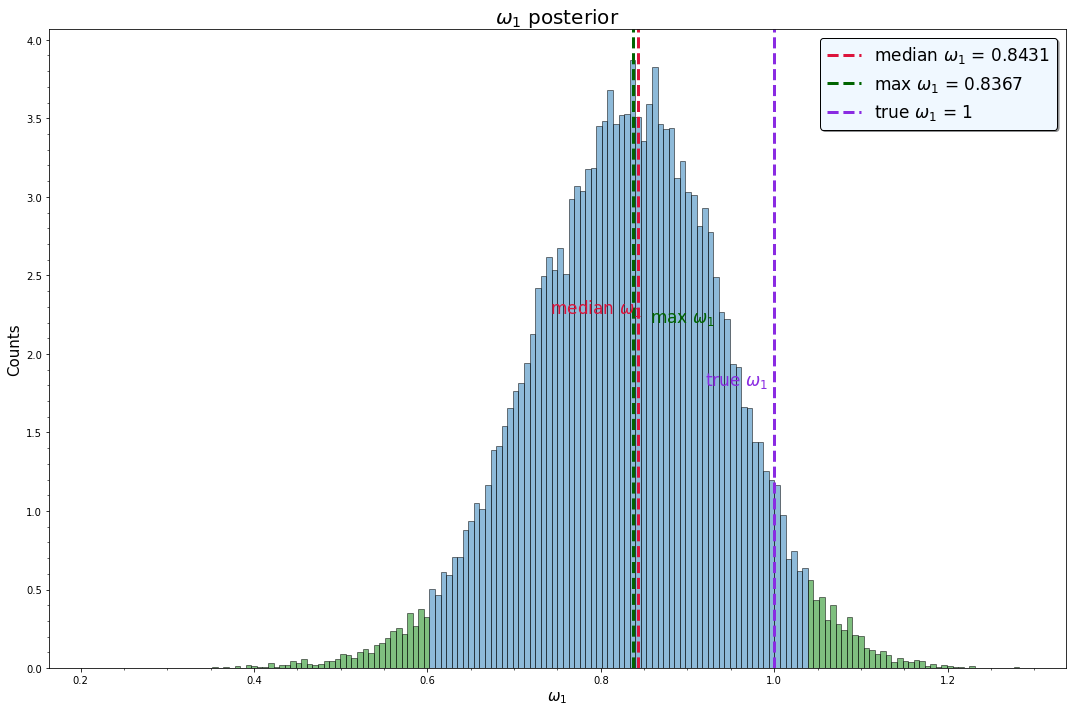

In [ ]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))
res_omega_1 = ax.hist(chain[:,0], bins='fd', edgecolor='black', alpha=0.5, density=True)

counts_omega_1 = res_omega_1[0]
edges_omega_1 = res_omega_1[1]
patches_omega_1 = res_omega_1[2]
tmp = np.cumsum(np.diff(edges_omega_1)*counts_omega_1)

max_index = np.argmax(counts_omega_1)
max_omega_1 = (edges_omega_1[max_index] + edges_omega_1[max_index + 1])/2
median_omega_1 = (edges_omega_1[len(tmp[tmp<0.5])+1] + edges_omega_1[len(tmp[tmp<0.5])+2])/2
print('Median value of omega_1:', round(median_omega_1, 4))
for i in range(len(tmp[tmp<0.025])):
    patches_omega_1[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_omega_1[i].set_facecolor('green')

ax.minorticks_on()
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('$\\omega_1$', fontsize=15)
ax.set_title('$\\omega_1$ posterior', fontsize=20)
ax.axvline(median_omega_1, color='crimson', linestyle='dashed',  linewidth=3, label='median $\omega_1$ = ' + str(round(median_omega_1, 4)))
ax.axvline(max_omega_1, color='darkgreen', linestyle='dashed',  linewidth=3, label='max $\omega_1$ = ' + str(round(max_omega_1, 4)))
ax.axvline(1, color='blueviolet', linestyle='dashed',  linewidth=3, label='true $\omega_1$ = 1')

ax.text(median_omega_1-0.102, 2.26, 'median $\omega_1$' , color='crimson', fontsize=17)
ax.text(max_omega_1+0.02, 2.2, 'max $\omega_1$', color='darkgreen', fontsize=17)
ax.text(1 - 0.08, 1.8, 'true $\omega_1$', color='blueviolet', fontsize=17)


print('Max value of omega_1:', round(max_omega_1, 4))
print('true value of omega_1:', 1.)

ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')

fig.tight_layout()

Median value of omega_2: 1.3401
Max value of omega_2: 1.1302
true value of omega_2: 0.9


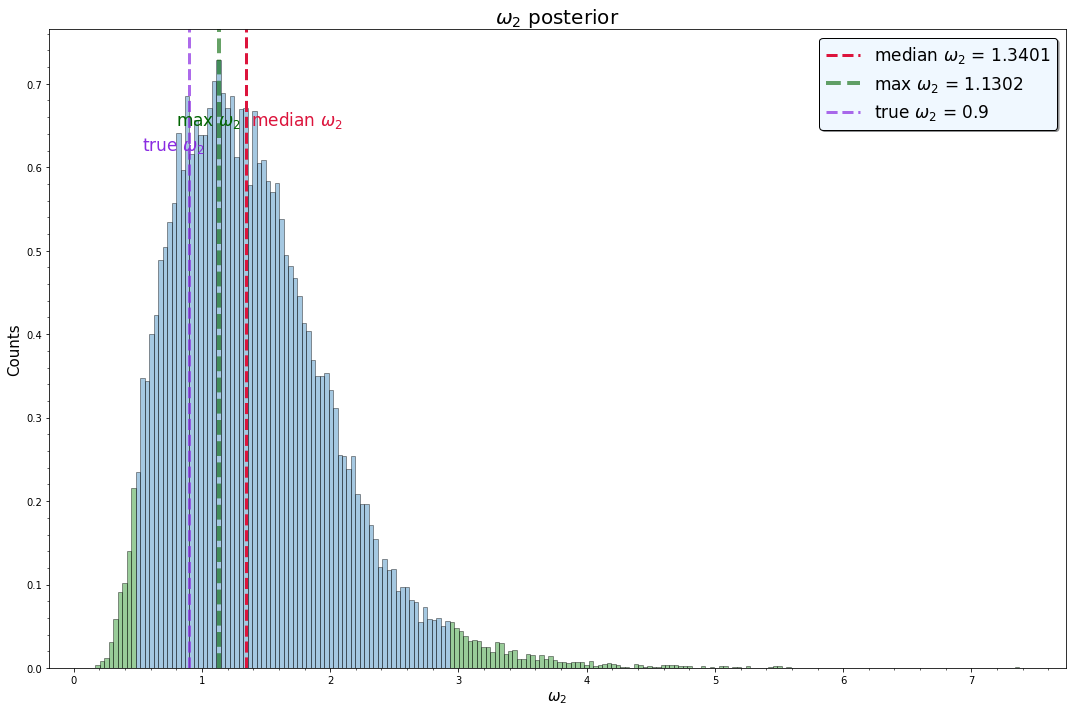

In [ ]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))



res_omega_2 = ax.hist(chain[:,1], bins='fd', edgecolor='black', alpha=0.4, density=True)

counts_omega_2 = res_omega_2[0]
edges_omega_2 = res_omega_2[1]
patches_omega_2 = res_omega_2[2]
tmp = np.cumsum(np.diff(edges_omega_2)*counts_omega_2)

max_index = np.argmax(counts_omega_2)
max_omega_2 = (edges_omega_2[max_index] + edges_omega_2[max_index + 1])/2
median_omega_2 = (edges_omega_2[len(tmp[tmp<0.5])+1] + edges_omega_2[len(tmp[tmp<0.5])+2])/2
print('Median value of omega_2:', round(median_omega_2, 4))
for i in range(len(tmp[tmp<0.025])):
    patches_omega_2[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_omega_2[i].set_facecolor('green')

ax.minorticks_on()
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('$\\omega_2$', fontsize=15)
ax.set_title('$\\omega_2$ posterior', fontsize=20)
ax.axvline(median_omega_2, color='crimson', linestyle='dashed',  linewidth=3 , label='median $\omega_2$ = ' + str(round(median_omega_2, 4)))
ax.axvline(max_omega_2, color='darkgreen', linestyle='dashed',  linewidth=4, alpha=0.6,  label='max $\omega_2$ = ' + str(round(max_omega_2, 4)))
ax.axvline(0.9, color='blueviolet', linestyle='dashed',  linewidth=3, alpha=0.7, label='true $\omega_2$ = 0.9')

ax.text(median_omega_2+0.04, 0.65, 'median $\omega_2$', color='crimson', fontsize=17)
ax.text(max_omega_2-0.33, 0.65, 'max $\omega_2$', color='darkgreen', fontsize=17)

ax.text(0.9 - 0.37, 0.62, 'true $\omega_2$', color='blueviolet', fontsize=17)

ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')
print('Max value of omega_2:', round(max_omega_2, 4))
print('true value of omega_2:', 0.9)


fig.tight_layout()

Median value of mu: 0.2939
Max value of mu: 0.2244
true value of mu: 0.1


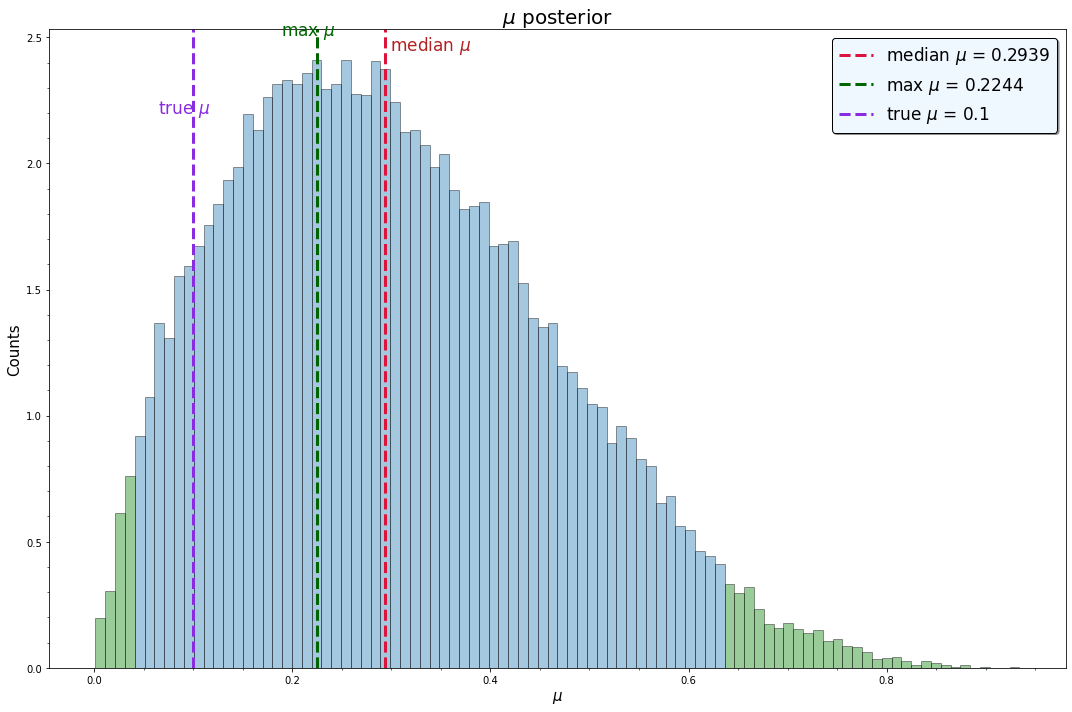

In [ ]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))

res_mu = ax.hist(chain[:,2], bins='fd', edgecolor='black', alpha=0.4, density=True)

counts_mu = res_mu[0]
edges_mu = res_mu[1]
patches_mu = res_mu[2]
tmp = np.cumsum(np.diff(edges_mu)*counts_mu)

max_index = np.argmax(counts_mu)
max_mu = (edges_mu[max_index] + edges_mu[max_index + 1])/2
median_mu = (edges_mu[len(tmp[tmp<0.5])+1] + edges_mu[len(tmp[tmp<0.5])+2])/2
print('Median value of mu:', round(median_mu, 4))
for i in range(len(tmp[tmp<0.025])):
    patches_mu[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_mu[i].set_facecolor('green')

ax.minorticks_on()
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('$\\mu$', fontsize=15)
ax.set_title('$\\mu$ posterior', fontsize=20)
ax.axvline(median_mu, color='crimson', linestyle='dashed',  linewidth=3, label='median $\mu$ = ' + str(round(median_mu, 4)))
ax.axvline(max_mu, color='darkgreen', linestyle='dashed',  linewidth=3, label='max $\mu$ = ' + str(round(max_mu, 4)))
ax.axvline(0.1, color='blueviolet', linestyle='dashed',  linewidth=3, label='true $\mu$ = 0.1')
ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')
ax.text(median_mu+0.005, 2.45, 'median $\mu$', color='firebrick', fontsize=17)
ax.text(max_mu-0.036, 2.51, 'max $\mu$ ', color='darkgreen', fontsize=17)
ax.text(0.1-0.036, 2.2, 'true $\mu$', color='blueviolet', fontsize=17)
print('Max value of mu:', round(max_mu, 4))
print('true value of mu:', 0.1)


fig.tight_layout()

Median value of nu: 1.2758
Max value of nu: 1.1681
true value of nu: 1


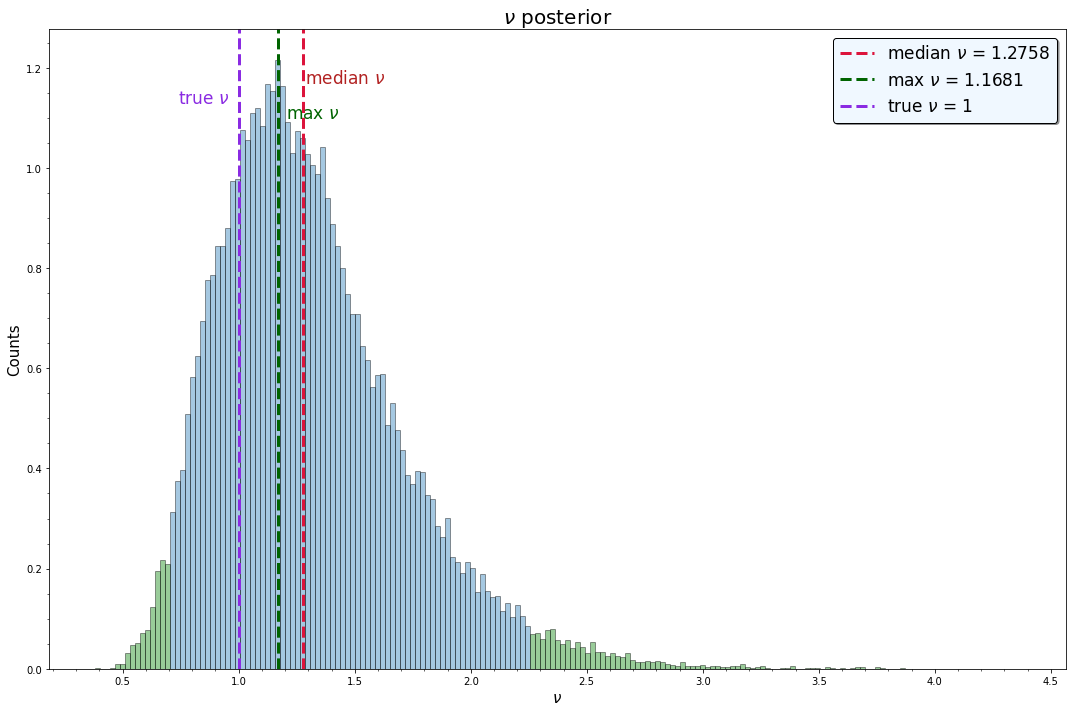

In [ ]:
fig, ax = plt.subplots(1,1 , figsize=(15, 10))

res_nu = ax.hist(chain[:,3], bins='fd', edgecolor='black', alpha=0.4, density=True)

counts_nu = res_nu[0]
edges_nu = res_nu[1]
patches_nu = res_nu[2]
tmp = np.cumsum(np.diff(edges_nu)*counts_nu)

max_index = np.argmax(counts_nu)
max_nu = (edges_nu[max_index] + edges_nu[max_index + 1])/2
median_nu = (edges_nu[len(tmp[tmp<0.5])+1] + edges_nu[len(tmp[tmp<0.5])+2])/2
print('Median value of nu:', round(median_nu, 4))
for i in range(len(tmp[tmp<0.025])):
    patches_nu[i].set_facecolor('green')
for i in range(len(tmp[tmp<0.975]), len(tmp)):
    patches_nu[i].set_facecolor('green')

ax.minorticks_on()
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('$\\nu$', fontsize=15)
ax.set_title('$\\nu$ posterior', fontsize=20)
ax.axvline(median_nu, color='crimson', linestyle='dashed',  linewidth=3, label='median $\\nu$ = ' + str(round(median_nu, 4)))
ax.axvline(max_nu, color='darkgreen', linestyle='dashed',  linewidth=3, label='max $\\nu$ = ' + str(round(max_nu, 4)))
ax.axvline(1, color='blueviolet', linestyle='dashed',  linewidth=3, label='true $\\nu$ = 1')
ax.legend(fontsize=17, facecolor='aliceblue', shadow = True, edgecolor='black')

ax.text(median_nu+0.0095, 1.17, 'median $ \\nu $', color='firebrick', fontsize=17)
ax.text(max_nu+0.036, 1.1, 'max $ \\nu $ ', color='darkgreen', fontsize=17)
ax.text(1-0.26, 1.13, 'true $ \\nu $', color='blueviolet', fontsize=17)

print('Max value of nu:', round(max_nu, 4))
print('true value of nu:', 1)


fig.tight_layout()

In [ ]:
print(
    "Mean acceptance fraction: {0:.7f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.5359400


In [ ]:
chain_df = pd.DataFrame(chain, columns=['omega1', 'omega2', 'mu', 'nu'])

display(chain_df.head())

,omega1,omega2,mu,nu
0,0.647865,0.586230,0.290162,0.614887
1,1.228014,0.620383,0.172202,0.834113
2,0.660508,1.161363,0.221857,1.237447
3,0.617880,0.722877,0.094701,0.890733
4,0.971463,1.322558,0.209368,1.034118


/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning:

The following kwargs were not used by contour: 'linewidth'

/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning:

The following kwargs were not used by contour: 'linewidth'

/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning:

The following kwargs were not used by contour: 'linewidth'

/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning:

The following kwargs were not used by contour: 'linewidth'

/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning:

The following kwargs were not used by contour: 'linewidth'

/shared-libs/python3.8/py/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning:

The following kwargs were not used by contour: 'linewidth'



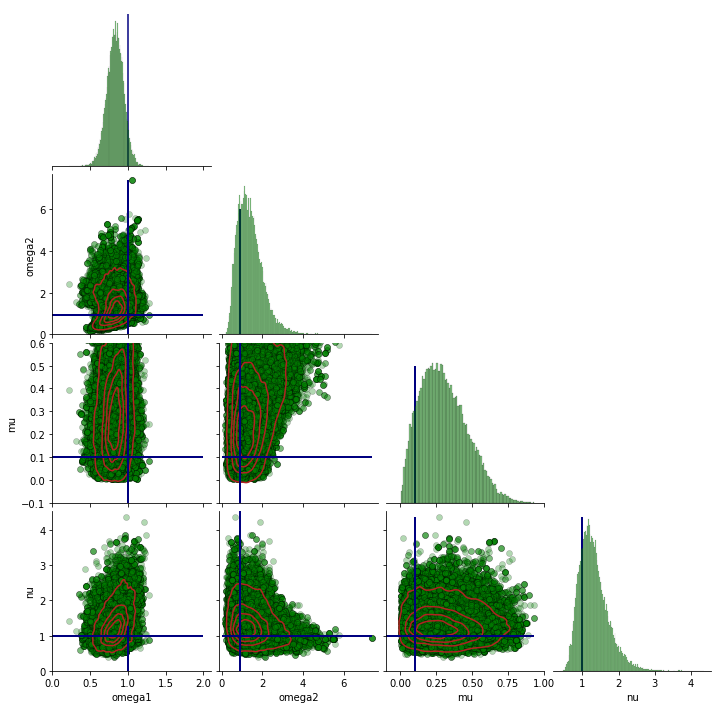

In [ ]:
g = sns.pairplot(chain_df, diag_kind="hist", corner=True, plot_kws={'color':'green', 'edgecolor':'black', 'alpha':0.3}, diag_kws={'color':'green', 'alpha':0.5})
g.map_lower(sns.kdeplot, levels=5, color="firebrick", linewidth=2)
axes = g.axes.ravel()
axes_2 = []
for ax in axes:
    if ax != None:
        axes_2.append(ax)
axes_2
axes_2[0].vlines(x=1, ymin=0, ymax=1, color='navy')
axes_2[1].vlines(x=1, ymin=0, ymax=np.max(chain[:,1]), linewidth=2, color='navy')
axes_2[2].set_ylim(bottom=0)
axes_2[4].set_ylim(bottom=0)
axes_2[6].set_ylim(bottom=0)
axes_2[0].set_ylim(bottom=0)

axes_2[1].hlines(y=0.9, xmin=0, xmax=2, linewidth=2, color='navy')
axes_2[2].vlines(x=0.9, ymin=0, ymax=6, linewidth=2, color='navy')
axes_2[3].vlines(x=1, ymin=-0.1, ymax=np.max(chain[:,2])+0.1, linewidth=2, color='navy')
axes_2[3].hlines(y=0.1, xmin=0, xmax=2, linewidth=2, color='navy')

axes_2[4].vlines(x=0.9, ymin=-0.1, ymax=np.max(chain[:,2])+0.1, linewidth=2, color='navy')
axes_2[4].set_ylim(bottom=-0.1, top=0.6)
axes_2[4].hlines(y=0.1, xmin=0, xmax=np.max(chain[:,1]), linewidth=2, color='navy')

axes_2[5].vlines(x=0.1, ymin=-0.1, ymax=0.5, linewidth=2, color='navy')
axes_2[6].vlines(x=1, ymin=0, ymax=np.max(chain[:,0]), linewidth=2, color='navy')
axes_2[6].hlines(y=1, xmin=0, xmax=2, linewidth=2, color='navy')

axes_2[6].set_xlim(left=0)
axes_2[7].vlines(x=0.9, ymin=0, ymax=np.max(chain[:,1]), linewidth=2, color='navy')
axes_2[7].hlines(y=1, xmin=0, xmax=np.max(chain[:,1]), linewidth=2, color='navy')
axes_2[8].vlines(x=0.1, ymin=0, ymax=np.max(chain[:,3]), linewidth=2, color='navy')

axes_2[8].hlines(y=1, xmin=-0.1, xmax=np.max(chain[:,2]), linewidth=2, color='navy')
axes_2[8].set_xlim(left=-0.1)
axes_2[9].vlines(x=1, ymin=0, ymax=np.max(chain[:,3]), linewidth=2, color='navy')


In [ ]:
df_chain = pd.DataFrame(chain, columns=["omega_1", "omega_2", "mu", 'nu'])

df_chain.head()

,omega_1,omega_2,mu,nu
0,0.647865,0.586230,0.290162,0.614887
1,1.228014,0.620383,0.172202,0.834113
2,0.660508,1.161363,0.221857,1.237447
3,0.617880,0.722877,0.094701,0.890733
4,0.971463,1.322558,0.209368,1.034118


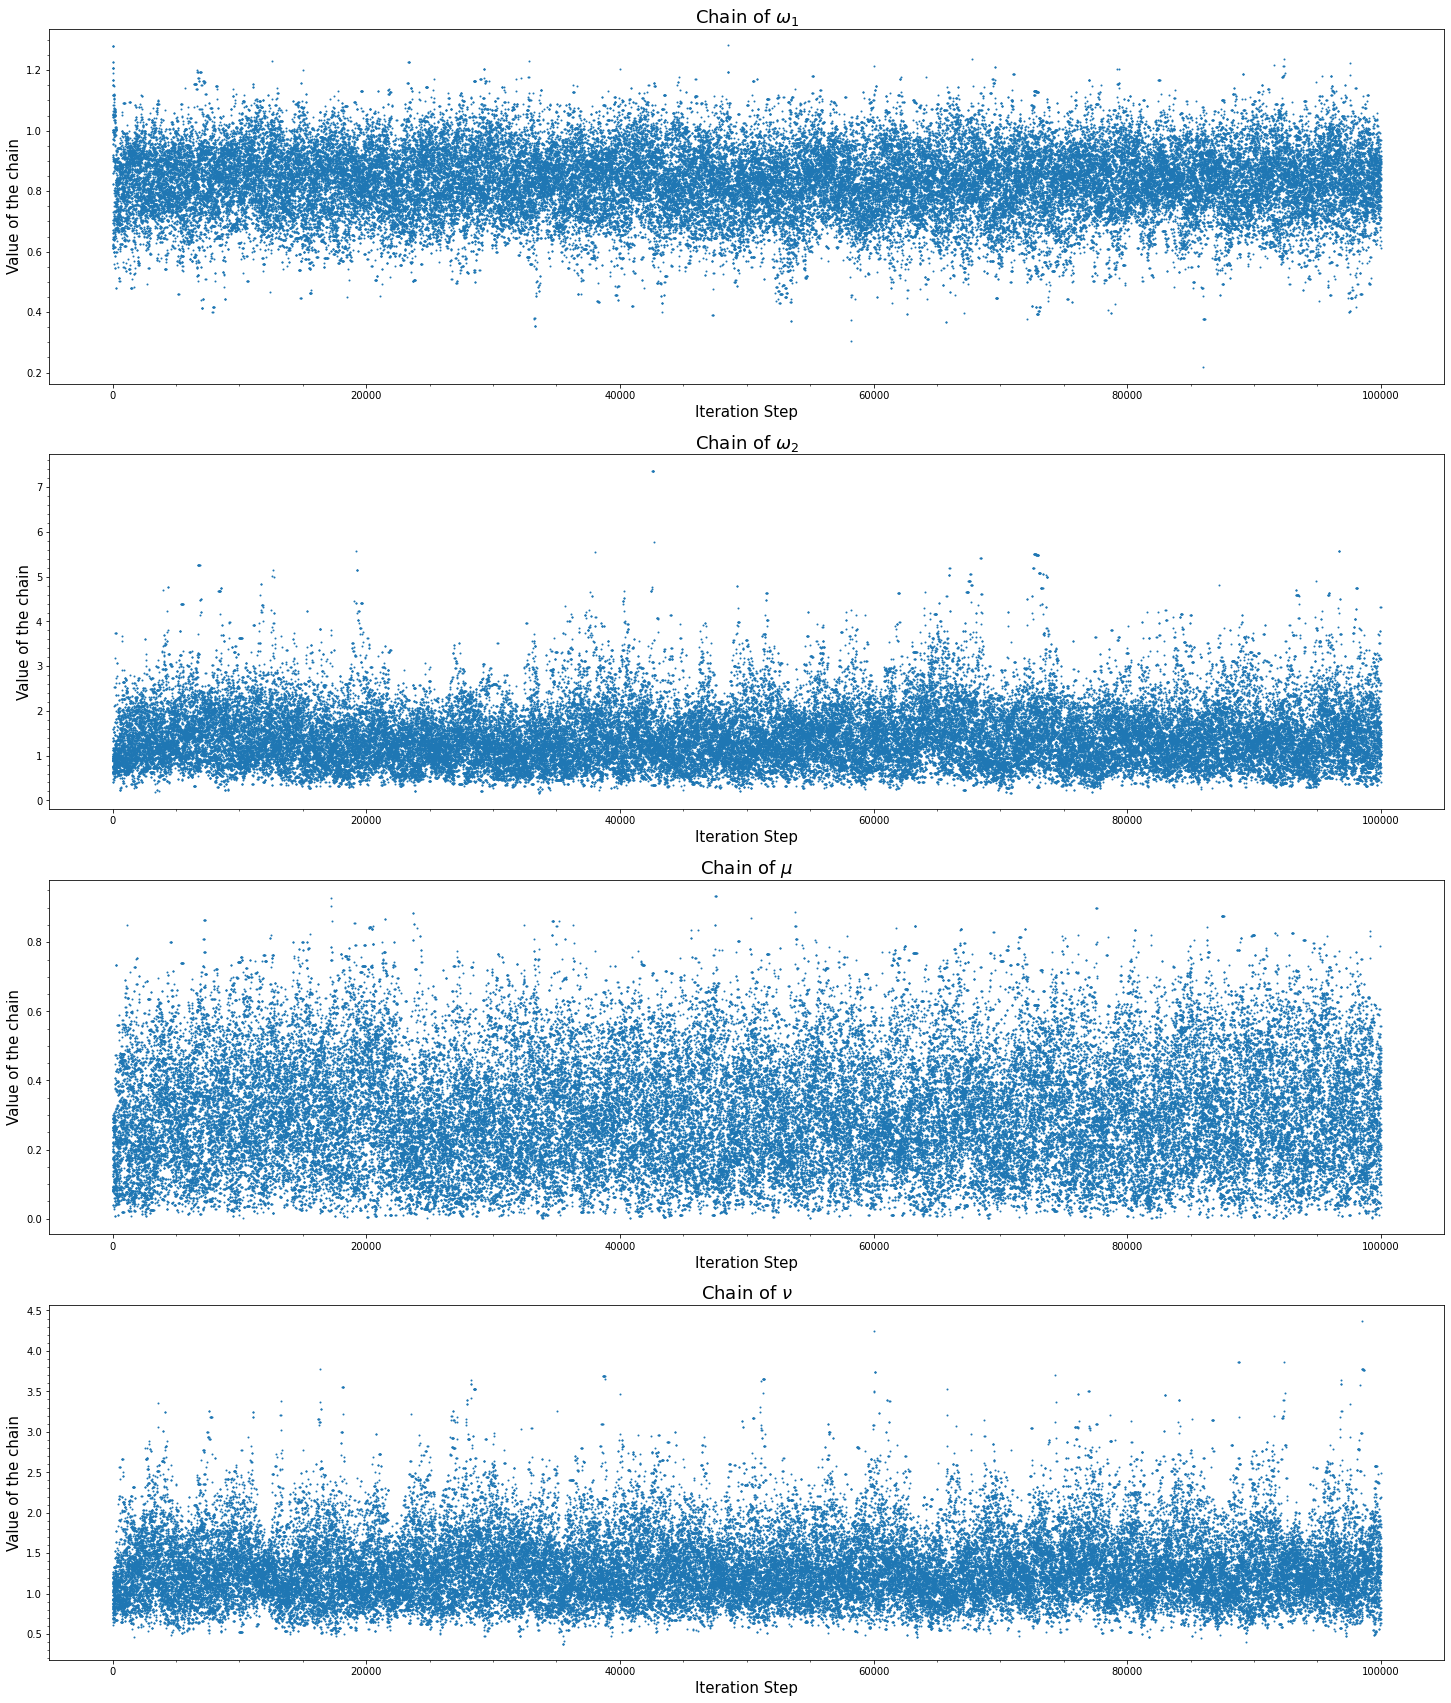

In [ ]:
fig , ax = plt.subplots(4,1, figsize=(25, 30))

title_list = ['$\omega_1$', '$\omega_2$', '$\mu$', '$\\nu$']
for i, i_title in zip(range(4), title_list):
    ax[i].scatter(range(0,100000) , chain[:100000,i], s=1)
    ax[i].set_ylabel('Value of the chain', fontsize=15)
    ax[i].set_xlabel('Iteration Step', fontsize=15)
    ax[i].set_title('Chain of '+i_title, fontsize=18)
    ax[i].minorticks_on()



# References
- Held J, Lorimer T, Pomati F, Stoop R, Albert C. Second-order phase transition in phytoplankton trait dynamics. _Chaos_. 2020;30(5):053109. doi:10.1063/1.5141755 
- emcee documentation: https://emcee.readthedocs.io/en/stable/

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=52dba48d-3798-4665-95fc-01a96804955b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>